In [18]:
import logging
# Configure logging
logging.basicConfig(
    level=logging.DEBUG,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Specify the log message format
    datefmt='%Y-%m-%d %H:%M:%S',  # Specify the date format
    handlers=[
        #logging.FileHandler('app.log'),  # Log messages to a file
        logging.StreamHandler()  # Also output log messages to the console
    ]
)
logger = logging.getLogger(__name__)
import pickle 
import networkx as nx
import time
from datetime import datetime, timezone
import os
import sys
import pandas as pd

In [21]:
"""The data stored in pickle format with version: 0.7.5 (python 3.7).
The type of graph object：networkx.classes.multidigraph.MultiDiGraph
Numbers of nodes: 2973489
Numbers of edges: 13551303
Average degree:   4.5574
Nodes' features：
    // The label. 1 means fishing mark node, otherwise 0.
    G.nodes[nodeName]['isp']；

Edges' features:
    G[node1][node2][0]['amount']        // The amount mount of the transaction.
    G[node1][node2][0]['timestamp']     // The timestamp of the transaction.				
							
* Notes * 
"""



def load_pickle(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)
logger.info("Loading the graph")
start = time.time()
G = load_pickle('/mnt/data/ethereum-phishing-transaction-network/MulDiGraph.pkl')
logger.info(f"Graph loaded in {time.time()-start} seconds.")
logger.info(f'Number of nodes: {G.number_of_nodes()}')
logger.info(f'Number of edges: {G.number_of_edges()}')


# save nodes and their labels to a csv
logger.info("Saving nodes and their labels to a csv")
start = time.time()
nodes = []
labels = []
for node in G.nodes():
    nodes.append(node)
    labels.append(G.nodes[node]['isp'])
dfnodes = pd.DataFrame({'node': nodes, 'label': labels})

2024-08-07 10:56:15 - INFO - Loading the graph
2024-08-07 10:56:37 - INFO - Graph loaded in 21.547139883041382 seconds.
2024-08-07 10:56:37 - INFO - Number of nodes: 2973489
2024-08-07 10:56:40 - INFO - Number of edges: 13551303
2024-08-07 10:56:40 - INFO - Saving nodes and their labels to a csv


In [1]:
logger.info("Processing the graph")
uniq = set()
start = time.time()
min_time = 1e20
max_time = 0
from_address = []
to_address = []
time_stamps = []
amounts = []

for ind, edge in enumerate(nx.edges(G)):
    (u, v) = edge
    eg = G[u][v][0]
    amo, tim = eg['amount'], eg['timestamp']
    uniq.add((u, v, tim))
    #uniq.add((u, v, amo, tim))
    min_time = min(min_time, tim)
    max_time = max(max_time, tim)
min_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(min_time))
max_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(max_time))
# print(min_time, max_time)
# print(len(uniq))
logger.info(f"Graph processed in {time.time()-start} seconds.")
logger.info(f'Number of unique transactions: {len(uniq)}')
#print an element from uniq
logger.info(f"An element from uniq: {list(uniq)[0]}")
logger.info(f'Minimum timestamp: {min_time}')
logger.info(f'Maximum timestamp: {max_time}')

2024-07-19 16:24:58 - INFO - Loading the graph
2024-07-19 16:25:13 - INFO - Graph loaded in 14.575936079025269 seconds.
2024-07-19 16:25:13 - INFO - Number of nodes: 2973489
2024-07-19 16:25:15 - INFO - Number of edges: 13551303
2024-07-19 16:25:15 - INFO - Processing the graph
2024-07-19 16:25:28 - INFO - Graph processed in 12.854514837265015 seconds.
2024-07-19 16:25:28 - INFO - Number of unique transactions: 5355155
2024-07-19 16:25:28 - INFO - An element from uniq: ('0x8b2d16de6c99ea66e8d93a256cb3105d6e2a3ad9', '0xf8c595d070d104377f58715ce2e6c93e49a87f3c', 1532624554.0)
2024-07-19 16:25:28 - INFO - Minimum timestamp: 2015-08-07 07:01:09
2024-07-19 16:25:28 - INFO - Maximum timestamp: 2019-01-19 09:32:09


In [2]:
import os
transactions_path = '/mnt/data/ethereum-phishing-transaction-network/transactions-c.csv'
if os.path.exists(transactions_path):
    columns_to_read = ['from_address', 'to_address', 'value', 'block_timestamp']
    columns_to_read = ['from_address', 'to_address', 'block_timestamp']
    dtype_dict = {
        'from_address': 'str',
        'to_address': 'str',
        #'value': 'str',
        'block_timestamp': 'str'  # assuming block_timestamp is initially read as string
    }
    df = pd.read_csv(transactions_path, usecols=columns_to_read, dtype=dtype_dict) 
    print(f"Read {len(df)} transactions from the csv")
    #df['value'] = df['value'].astype(float)
    df['block_timestamp'] = pd.to_datetime(df['block_timestamp']).view('int64') / 10**9
    # print a row of the dataframe
    print(f"A row from the dataframe: {df.iloc[0]}")
    #exists = set(zip(df['from_address'], df['to_address'], df['value'], df['block_timestamp']))
    exists = set(zip(df['from_address'], df['to_address'], df['block_timestamp']))
    diff = uniq - exists

Read 5256894 transactions from the csv
A row from the dataframe: from_address       0xc3d9c17d7f6988c0fe7ebe929c47efccbd92be13
to_address         0x0d64b06929f797d641064521705714498618fe1e
block_timestamp                                  1494731739.0
Name: 0, dtype: object


/tmp/ipykernel_3972980/1141260626.py:15: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['block_timestamp'] = pd.to_datetime(df['block_timestamp']).view('int64') / 10**9


In [3]:
# compare the transactions in the graph with the transactions in the csv
print("Number of transactions in the csv: ", len(exists))
print("Number of transactions in the graph but not in the csv: ", len(diff))
print("Number of transactions in the csv but not in the graph: ", len(exists - uniq))

Number of transactions in the csv:  5242514
Number of transactions in the graph but not in the csv:  136344
Number of transactions in the csv but not in the graph:  23703


In [4]:
# compare the nodes in the graph with the from_address and to_address in the csv
nodes = set(G.nodes())
from_addresses = set(df['from_address'])
to_addresses = set(df['to_address'])
csv_nodes = from_addresses.union(to_addresses)
print(f"Number of nodes in the graph: {len(nodes)}")
print(f"Number of nodes in the csv: {len(csv_nodes)}")
print(f"Number of nodes in the graph but not in the csv: {len(nodes - csv_nodes)}")
print(f"Number of nodes in the csv but not in the graph: {len(csv_nodes - nodes)}")
# what is the percentage of labels of the nodes in the graph but not in the csv
labels = [G.nodes[node]['isp'] for node in (nodes - csv_nodes)]
print(f"Percentage of labels in the graph but not in the csv: {sum(labels)/len(labels)}")
print(f"Ilicit missing nodes {sum(labels)}")


Number of nodes in the graph: 2973489
Number of nodes in the csv: 2890207
Number of nodes in the graph but not in the csv: 83282
Number of nodes in the csv but not in the graph: 0
Percentage of labels in the graph but not in the csv: 7.204437933767201e-05
Ilicit missing nodes 6


In [31]:
transactions_path = '/mnt/data/ethereum-phishing-transaction-network/transactions.csv'
names = [
    'nonce',
    'from_address',
    'to_address',
    'transaction_index',
    'value',
    'gas',
    'gas_price',
    #'receipt_status',
    'block_timestamp',
    # 'phishing',
]
dtypes = {
    'nonce': 'float64',
    'from_address': 'str',
    'to_address': 'str',
    'transaction_index': 'category',
    'value': 'float64',
    'gas': 'float64',
    'gas_price': 'float64',
    #'receipt_status': 'category',
}
import numpy as np
# Define converter function
def to_float_or_nan(value):
    try:
        return float(value)
    except ValueError:
        return np.nan
df = pd.read_csv(transactions_path, usecols=names, dtype=dtypes, parse_dates=['block_timestamp'], converters={'receipt_gas_used': to_float_or_nan})
# print statistics for each column of the dataframe
for col in df.columns:
    print(f"Statistics for column {col}")
    print(df[col].describe())
    # print the number of nans in the column
    print(f"Number of nans in column {col}: {df[col].isna().sum()}")
    print()

<Axes: >

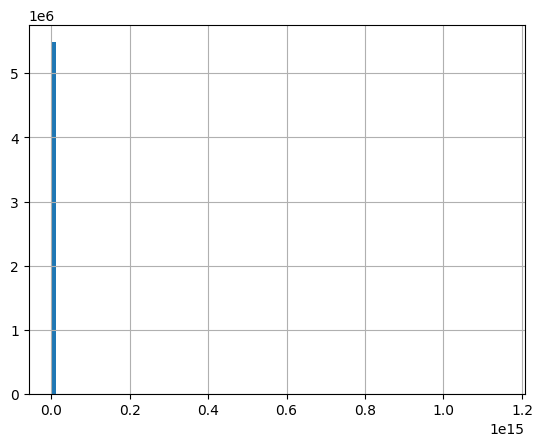

In [30]:
df['gas_price'].hist(bins=100)

<Axes: >

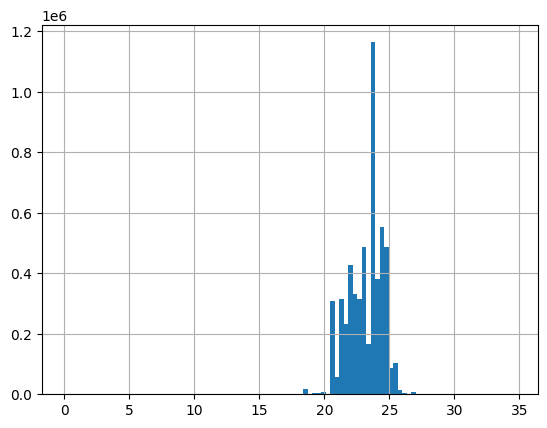

In [31]:
np.log1p(df['gas_price']).hist(bins=100)

In [19]:
import numpy as np
# renumber from_address and to_address starting from 0 and update the dataframe
unique_ids = pd.concat([df['from_address'], df['to_address']]).unique()
# create a mapping from the original ID to a new ID
id_map = {old_id: new_id for new_id, old_id in enumerate(unique_ids)}
# replace the original IDs with the new IDs
df['from_address'] = df['from_address'].apply(lambda x: id_map[x])
df['to_address'] = df['to_address'].apply(lambda x: id_map[x])
# convert timestamp to UNIX
df['block_timestamp'] = pd.to_datetime(df['block_timestamp']).astype('int64') / 10**9
#remove nodes that are not in the transactions
dfnodes = dfnodes[dfnodes['node'].isin(unique_ids)]
dfnodes['node'] = dfnodes['node'].apply(lambda x: id_map[x])

# normalize numerical columns
for col in df.columns:
    print(col)
    if col in ['from_address', 'to_address', 'phishing', 'receipt_status', 'block_timestamp', 'transaction_index']:
        continue
    df[col] = np.log1p(df[col])
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

nonce
transaction_index
from_address
to_address
value
gas
gas_price
block_timestamp


In [20]:
print(unique_ids[:10])

['0xc3d9c17d7f6988c0fe7ebe929c47efccbd92be13'
 '0xa95350d70b18fa29f6b5eb8d627ceeeee499340d'
 '0x923f9e3a6348de0583c91c842aa10e713e2e6f20'
 '0x4c34ae54dc716808e94af3d1d638b8ea3a23fa9b'
 '0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be'
 '0x2fb63188a04661212b657fd0173f9a58be9ed452'
 '0xcdbf91f5447b17744273a8baae8d40d06b5d0a0d'
 '0xb295f54ada59a2d41033cb019d10314e49b1ab69'
 '0xd95772178ad239f7348798cd61f2c6b41f69e5d9'
 '0x3261b3e1e4da997e6c0493c0f5059f254d8cd831']


In [23]:
print(dfnodes.head())
len(dfnodes)

      node  label
0     2576      0
1  1720430      0
2  2409198      1
3  1597191      0
4    17867      0


2890207

In [22]:
# save the dataframe to a csv file
# if not os.path.exists('/mnt/data/ethereum-phishing-transaction-network/ethereum-phishing-transaction-network.csv'):
dfnodes.to_csv('/mnt/data/ethereum-phishing-transaction-network/nodes.csv', index=False)
df.to_csv('/mnt/data/ethereum-phishing-transaction-network/ethereum-phishing-transaction-network.csv', index=False)

In [24]:
names = [
    'nonce',
    'from_address',
    'to_address',
    #'transaction_index',
    'value',
    'gas',
    'gas_price',
    #'receipt_status',
    'block_timestamp',
    # 'phishing',
]
dtypes = {
    'nonce': 'float64',
    'from_address': 'str',
    'to_address': 'str',
    'transaction_index': 'category',
    'value': 'float64',
    'gas': 'float64',
    'gas_price': 'float64',
    #'receipt_status': 'category',
}
df = pd.read_csv('/mnt/data/ethereum-phishing-transaction-network/ethereum-phishing-transaction-network.csv', usecols=names, dtype=dtypes,  parse_dates=['block_timestamp'])
# print statistics for each column of the dataframe
for col in df.columns:
    print(f"Statistics for column {col}")
    print(df[col].describe())
    # print the number of nans in the column
    print(f"Number of nans in column {col}: {df[col].isna().sum()}")
    print()

/tmp/ipykernel_3983762/2379292951.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('/mnt/data/ethereum-phishing-transaction-network/ethereum-phishing-transaction-network.csv', usecols=names, dtype=dtypes,  parse_dates=['block_timestamp'])


Statistics for column nonce
count    5.483921e+06
mean     1.950655e-01
std      1.724360e-01
min      0.000000e+00
25%      4.159354e-02
50%      1.625014e-01
75%      2.939037e-01
max      1.000000e+00
Name: nonce, dtype: float64
Number of nans in column nonce: 0

Statistics for column from_address
count     5483921
unique    2091826
top           158
freq        12773
Name: from_address, dtype: object
Number of nans in column from_address: 0

Statistics for column to_address
count     5483921
unique    1032475
top       2092442
freq        11908
Name: to_address, dtype: object
Number of nans in column to_address: 0

Statistics for column value
count    5.483921e+06
mean     3.032659e-01
std      3.610645e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.243911e-01
max      1.000000e+00
Name: value, dtype: float64
Number of nans in column value: 0

Statistics for column gas
count    5.483921e+06
mean     1.947506e-01
std      1.438541e-01
min      0.000

In [2]:
%load_ext autoreload
%autoreload 2
# add parent directory to the path
import sys
sys.path.append('../')
from src.datasets import EthereumPhishingTransactions, EthereumPhishingNodes
from src.datasets.util.mask import PretrainType
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
dataset = EthereumPhishingTransactions(
    root='/mnt/data/ethereum-phishing-transaction-network/ethereum-phishing-transaction-network-c.csv', 
    pretrain={PretrainType.MASK, PretrainType.LINK_PRED},
    split_type='temporal',
    
    splits=[0.6, 0.2, 0.2], 
    khop_neighbors=[100, 100]
)
start = time.time()
dataset.materialize()
logger.info(f"Dataset materialized in {time.time()-start} seconds.")

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [9]:
nodes = EthereumPhishingNodes(root='/mnt/data/ethereum-phishing-transaction-network/nodes.csv')
nodes.materialize()

Masked applied
Tensor frame created


EthereumPhishingNodes()

In [14]:
from torch_frame.data import DataLoader
train_dataset, val_dataset, test_dataset = nodes.split()
tensor_frame = nodes.tensor_frame 
train_loader = DataLoader(train_dataset.tensor_frame, batch_size=2048, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset.tensor_frame, batch_size=2048, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset.tensor_frame, batch_size=2048, shuffle=False, num_workers=4)

In [16]:
batch = next(iter(train_loader))
print(batch)
print(batch.y)
print(sum(batch.y))

TensorFrame(
  num_cols=1,
  num_rows=2048,
  numerical (1): ['node'],
  has_target=True,
  device='cpu',
)
tensor([0, 0, 0,  ..., 0, 0, 0])
tensor(2)


In [27]:
df = pd.read_csv('/mnt/data/ethereum-phishing-transaction-network/dummy-c.csv')
m = max(df['from_address'].max(), df['to_address'].max())
dummynodes = pd.DataFrame({'node': range(m+1), 'label': 0})
dummynodes.to_csv('/mnt/data/ethereum-phishing-transaction-network/dummy-nodes.csv', index=False)

In [3]:
edges = pd.read_csv('/mnt/data/ethereum-phishing-transaction-network/ethereum-phishing-transaction-network.csv')
nodes= pd.read_csv('/mnt/data/ethereum-phishing-transaction-network/nodes.csv')

In [7]:
edges = pd.read_csv('/mnt/data/ethereum-phishing-transaction-network/dummy.csv')
nodes= pd.read_csv('/mnt/data/ethereum-phishing-transaction-network/dummy-nodes.csv')

In [8]:
import pandas as pd

# Assuming nodes and edges are pandas DataFrames

# Get the first transaction timestamp for each from_address
from_min_timestamp = edges.groupby('from_address')['block_timestamp'].min().reset_index()
from_min_timestamp.columns = ['node', 'first_transaction']

# Get the first transaction timestamp for each to_address
to_min_timestamp = edges.groupby('to_address')['block_timestamp'].min().reset_index()
to_min_timestamp.columns = ['node', 'first_transaction']

# Concatenate both results and take the minimum timestamp for each node
combined = pd.concat([from_min_timestamp, to_min_timestamp])

# Group by node and take the earliest transaction
first_transactions = combined.groupby('node')['first_transaction'].min().reset_index()

# Merge with the nodes DataFrame
nodes = nodes.merge(first_transactions, on='node', how='left')


nodes.head()

,node,label,first_transaction
0,0,0,1.494732e+09
1,1,0,1.497959e+09
2,2,0,1.507349e+09
3,3,0,1.507305e+09
4,4,0,1.502329e+09


In [9]:
# Save the result
nodes.to_csv('/mnt/data/ethereum-phishing-transaction-network/dummy-nodes.csv', index=False)